In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import Progbar
tf.__version__

'2.3.1'

In [2]:
batch_size = 64
epochs = 25
z_dim = 100
c_lambda = 10
train_size = 60000


In [3]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./255)
training_data = data_gen.flow_from_directory(directory = "../input/celeba-dataset/img_align_celeba",
                                             target_size= (224,224),
                                             batch_size = batch_size,
                                             shuffle = True,
                                             class_mode = None,
                                             classes = None
                                            )

Found 202599 images belonging to 1 classes.


In [4]:
def get_noise(batch_size , z_dim):
    return tf.random.normal([batch_size,z_dim])

In [5]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*512 , input_shape = (z_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7,7,512)))
    
    model.add(tf.keras.layers.UpSampling2D()) #14x14
    model.add(tf.keras.layers.Conv2D(256 , (5,5) , strides = (1,1), padding = "same")) #14x14
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.UpSampling2D())  #28X28
    model.add(tf.keras.layers.Conv2D(128 , (5,5) , strides = (1,1), padding = "same")) #28x28
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.UpSampling2D())  #56X56
    model.add(tf.keras.layers.Conv2D(64 , (5,5) , strides = (1,1), padding = "same")) #56x56
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.UpSampling2D())  #112X112
    model.add(tf.keras.layers.Conv2D(32 , (5,5) , strides = (1,1), padding = "same")) #112x112
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.UpSampling2D())  #224X224
    model.add(tf.keras.layers.Conv2D(3 , (5,5) , strides = (1,1), padding = "same" , activation = "tanh")) #28x28
        
    return model     

In [6]:
#testing generator
s = tf.random.normal([1,z_dim])

gen = generator()
x = gen(s)
assert x.shape == (1,224,224,3)

In [7]:
def critic():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(5,5), strides = (2,2) , padding = "same"  ,input_shape = (224,224,3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(64,(5,5), strides = (2,2) , padding = "same"  ,))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Conv2D(128,(5,5), strides = (2,2) , padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256,(5,5), strides = (2,2) , padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1028,activation = "relu"))
    model.add(tf.keras.layers.Dense(1))
    
    
    return model


In [8]:
#testing Critic
crit = critic()
s = tf.random.normal([1,224,224,3])
x = crit(s)
x

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01438294]], dtype=float32)>

In [9]:
@tf.function
def get_gradient(crit,real,fake,epsilon):
    
    mixed = real * epsilon + (1 - epsilon)* fake
    with tf.GradientTape() as gtape:
        gtape.watch(mixed)
        mixed_score = crit(mixed , training = True)
        
    grad = gtape.gradient(mixed_score , mixed)
    return grad

In [10]:
def gradient_penalty(gradient):
    
    grad_norm = tf.norm(gradient)
    penalty = tf.reduce_mean((grad_norm - 1)**2)
    
    return penalty
    

In [11]:
def gen_loss(fake_output):
    
    
    loss = -1 * tf.reduce_mean(fake_output)
    return loss

In [12]:

def critic_loss(fake_output , real_output , gp , c_lambda):
    
    
    loss = -(tf.reduce_mean(real_output) - tf.reduce_mean
             (fake_output)) + (c_lambda * gp)
    return loss

In [13]:
#testing gradient
real = tf.random.normal([1,224,224,3])
fake = tf.random.normal([1,224,224,3])
grad = get_gradient(crit ,real = real , fake = fake , epsilon = 0.1)
grad.shape

TensorShape([1, 224, 224, 3])

In [14]:
#testing gradient_panalty
penalty = gradient_penalty(grad)
penalty

<tf.Tensor: shape=(), dtype=float32, numpy=0.18428986>

In [15]:
#testinf critic's loss
fake_output = crit(fake)
real_output = crit(real)

loss = critic_loss(fake_output, real_output , penalty , 0.5)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.17687602>

In [16]:
gen_optimizer = tf.keras.optimizers.Adam(0.002,0.5,0.99)
critic_optimizer = tf.keras.optimizers.Adam(0.002,0.5,0.99)

In [17]:
@tf.function
def train_step(real_images):
    
    
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as crit_tape:
        
        noises = get_noise(real_images.shape[0] , z_dim)
        fake_images = gen(noises,training = True)
        fake_outputs = crit(fake_images , training = True)
        real_outputs = crit(real_images , training = True)
        epsilon = tf.random.uniform([real_images.shape[0],224,224,3])
        grad = get_gradient(crit,real = real_images,fake = fake_images,epsilon = epsilon)
        penalty = gradient_penalty(grad)
        ######################################################################
        g_loss = gen_loss(fake_outputs )
        c_loss = critic_loss(fake_outputs, real_outputs , penalty , c_lambda )
        
    gen_grad = gen_tape.gradient(g_loss , gen.trainable_variables)
    critic_grad = crit_tape.gradient(c_loss, crit.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gen_grad ,gen.trainable_variables ))
    critic_optimizer.apply_gradients(zip(critic_grad , crit.trainable_variables))
    
    return g_loss , c_loss
    
    
    


In [18]:
def train(dataset , epochs):
    
    
    mean_gen_loss_list = []
    mean_critic_loss_list = []
    
    for epoch in range(epochs):
        gen_loss_list = []
        critic_loss_list = []
        
        progress_bar = Progbar(train_size)
        i = 0
        for image in dataset:
            i = i + batch_size
            if i <= train_size:
                g_loss, c_loss , = train_step(image)
                gen_loss_list.append(g_loss)
                critic_loss_list.append(c_loss)
                progress_bar.add(batch_size)
            else:
                break
            
        
        
        mean_g_loss = sum(gen_loss_list)/len(gen_loss_list)
        mean_c_loss = sum(critic_loss_list)/len(critic_loss_list)
        mean_gen_loss_list.append(mean_g_loss)
        mean_critic_loss_list.append(mean_c_loss)    
            
        print (f'Epoch {epoch+1}, gen loss={mean_g_loss},critic loss={mean_c_loss}')
        
    return mean_gen_loss_list , mean_critic_loss_list
            
    

In [19]:
G_loss , C_loss = train(training_data , epochs)

59968/60000 [============================>.] - ETA: 0sEpoch 25, gen loss=-1088.4306640625,critic loss=-0.4880548417568207


In [20]:
os.mkdir("/kaggle/working/saved_models")
tf.saved_model.save(gen , "/kaggle/working/saved_models")

In [2]:
#loading pretrained generator
gen = tf.saved_model.load("saved_models\WGAN_CelebA_model\saved_models_2.0")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


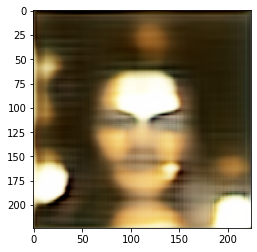

In [11]:
noise = tf.random.normal([1,100])
image = gen(noise).numpy()
image = image.reshape(224,224,3) 
plt.imshow(image )

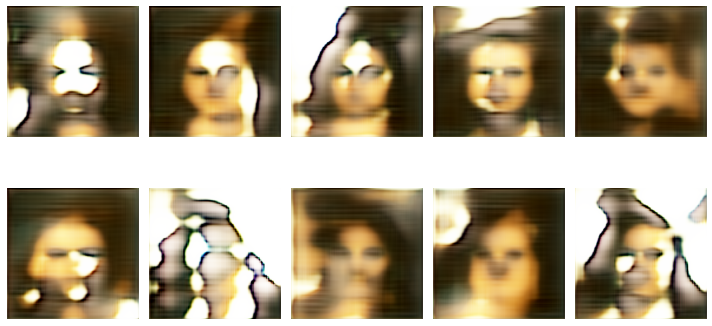

In [42]:
#mode collapse is not observed 


noises = np.random.randn(10,100)
images = []
noises[0].reshape(1,100)
for i in range(noises.shape[0]):
    images.append(gen(noises[i].reshape(1,100)).numpy().reshape(224,224,3))

fig , ax = plt.subplots(2,5 , figsize = (10,8))

for j in range(2):
  for i in range(5):
    plt.sca(ax[j][i])
    if j == 0:
      plt.imshow(images[i] )
    else:
      plt.imshow(images[i+5])
    plt.axis("off")
    plt.tight_layout()

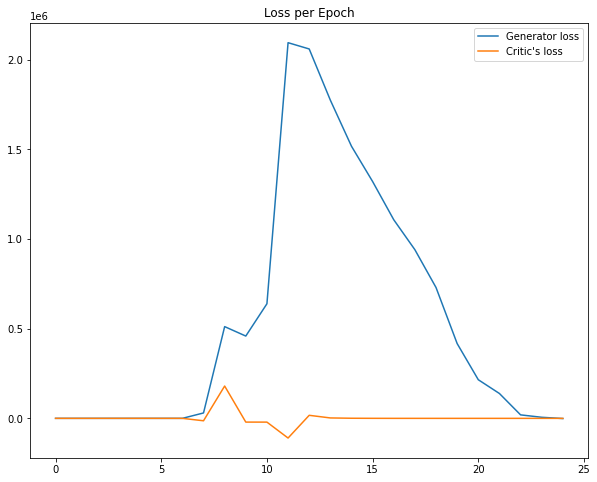

In [23]:
plt.figure(figsize=(10,8))
plt.plot(G_loss , label = "Generator loss" , linewidth = 1.5)
plt.plot(C_loss, label = "Critic's loss" , linewidth = 1.5)
plt.legend()
plt.title("Loss per Epoch")
plt.show()